## Workflow to analyze Photometry data

```bash
jupyter nbconvert "D:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20221005_001400_workflow_pyPhot_PavAll_last5.ipynb" --to="python" --output-dir="D:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical" --output="nb20221005_001400_workflow_pyPhot_PavAll_last5.ipynb"
```

### Imports

In [1]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *

        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment


### Variables

In [2]:
import pandas as pd

trial_window = [-2000, 6000] # in ms

# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 2000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder, _ = os.path.split(os.path.split(os.getcwd())[0])

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = os.path.join(basefolder,'params\\tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

# photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\kms_pyphotometry'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'


### Tasks
- A tasks definition file (.csv) contains all the information to perform the extractions of behaviorally relevant information from **PyControl** files, for each **task** file. It includes what are the **triggers** of different trial types, what **events** to extract (with time data), and what are events or printed lines that could be relevant to determine the **conditions** (e.g: free reward, optogenetic stimulation type, etc.)
- To analyze a new task you need to append task characteristics like **task** filename, **triggers**, **events** and **conditions**

In [3]:
tasks = pd.read_csv(tasksfile, usecols = [1,2,3,4], index_col = False)
tasks

,task,triggers,events,conditions
0,lick_go_nogo,go; nogo,bar; bar_off; spout,free_reward
1,lick_go_nogo_unconditionned,go; nogo,bar; bar_off; spout,free_reward
2,lick_go_nogo_unconditionned_opto,go; nogo,bar; bar_off; spout,free_reward
3,reaching_go_nogo,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
4,reaching_go_nogo_jc,CS_plus; CS_minus,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
5,reaching_go_nogo_opto_continuous,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset; s_go_sham; s_go_...
6,reaching_go_nogo_opto_sinusoid,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
7,reaching_go_nogo_opto_sinusoid_spout,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
8,reaching_go_nogo_reversal,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
9,reaching_go_nogo_reversal_incentive,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...


### Optional

Transfer Files from hierarchical folders by tasks to flat folders, for photometry and behaviour files

2m 13.9s

If we obtain list of files in source and dest at first and then only perform comparison on them,
This should be much faster

In [4]:
photo_root_dir = 'T:\\Data\\head-fixed\\pyphotometry\\data'
pycontrol_root_dir = 'T:\\Data\\head-fixed\\pycontrol'

root_folders = [photo_root_dir, pycontrol_root_dir]
horizontal_folder_pycontrol = 'T:\\Data\\head-fixed\\test_folder\\pycontrol'
horizontal_folder_photometry = 'T:\\Data\\head-fixed\\test_folder\\photometry'

copy_files_to_horizontal_folders(root_folders, horizontal_folder_pycontrol, horizontal_folder_photometry)

### Create an experiment object

This will include all the pycontrol files present in the folder_path directory (do not include subdirectories)

In [14]:
# Folder of a full experimental batch, all animals included

# Enter absolute path like this
# pycontrol_files_path = r'T:\Data\head-fixed\test_folder\pycontrol'

# or this if you want to use data from the sample_data folder within the package
pycontrol_files_path = os.path.join(basefolder,'sample_data\\pycontrol')
pycontrol_files_path = r'T:\Data\head-fixed\kms_pycontrol'

# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(pycontrol_files_path)

# Only use if the Experiment cohort as been processed by trials before
# TODO: assess whether this can be removed or not
exp_cohort.by_trial = True

Saved sessions loaded from: sessions.pkl


In [13]:
exp_cohort.sessions[0].df_conditions


,trigger,success,valid
trial_nb,,,
1,CS_Go,False,True
2,CS_Go,False,True
3,CS_Go,False,True
4,CS_Go,False,True
5,CS_Go,False,True
...,...,...,...
78,CS_Go,False,True
79,CS_Go,False,True
80,CS_Go,True,True


### Perform extraction of behavioural information by trial

5m55.4s

In [15]:
# Process the whole experimental folder by trials
exp_cohort.process_exp_by_trial(trial_window, timelim, tasksfile, blank_spurious_event='spout', blank_timelim=[0, 65])

# Save the file as sessions.pkl in folder_path
# exp_cohort.save() # Do I need to save this???


No event  'spout'  found:  45 2022-04-27 15:57:48 pavlovian_nobar_nodelay
No event  'spout'  found:  42 2022-04-28 12:53:21 pavlovian_nobar_nodelay
No event  'spout'  found:  45 2022-05-06 12:27:18 pavlovian_nobar_nodelay
reaching_go_spout_cued_uncued 41 2022-05-11 17:30:36 25 29
reaching_go_spout_cued_uncued 42 2022-05-11 17:32:14 5 0
reaching_go_spout_cued_uncued 42 2022-05-11 17:47:30 38 3
reaching_go_spout_cued_uncued 43 2022-05-11 19:24:51 34 57
reaching_go_spout_cued_uncued 44 2022-05-11 19:24:51 22 37
reaching_go_spout_cued_uncued 45 2022-05-11 19:27:52 25 55
reaching_go_spout_cued_uncued 41 2022-05-12 15:28:29 33 105
reaching_go_spout_cued_uncued 42 2022-05-12 15:33:00 44 88
reaching_go_spout_cued_uncued 43 2022-05-12 16:32:18 51 61
reaching_go_spout_cued_uncued 44 2022-05-12 16:32:18 30 40
reaching_go_spout_cued_uncued 45 2022-05-12 16:37:28 11 0
reaching_go_spout_cued_uncued 45 2022-05-12 16:54:09 5 2
reaching_go_spout_cued_uncued 41 2022-05-16 13:21:21 3 0
reaching_go_spout_

### Match with photometry, videos, and DeepLabCut files

The following Warning : 

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads...

is due to rsync function for photometry-pycontrol alignment

2m10.9s


In [16]:
# Find if there is a matching photometry file and if it can be used:
# rsync synchronization pulses matching between behaviour and photometry
from copy import deepcopy

exp_cohort.match_to_photometry_files(photometry_dir, rsync_chan, verbose=False)

# Find matching videos
exp_cohort.match_sessions_to_files(video_dir, ext='mp4')

# FInd matching DeepLabCut outputs files
exp_cohort.match_sessions_to_files(video_dir, ext='h5')

exp_cohort.save()

exp_cohort_copy = deepcopy(exp_cohort)


c:\Users\phar0528\Anaconda3\envs\trialexp\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\phar0528\Anaconda3\envs\trialexp\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\phar0528\Anaconda3\envs\trialexp\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\phar0528\Anaconda3\envs\trialexp\lib\site-packages\sklearn\cluster\_kmeans.p

### Define conditions and groups for extraction

Pavlovian

In [17]:

# List of uncued conditions as listed on the tasks .csv file for task pavlovian_nobar_nodelay:
# free_reward_timer; reward spout cued; reward bar cued; reward bar_off; reward spout uncued; reward bar uncued; reward free; reward free_uncued

# Many combinations possible
conditions_dict0 = {'success': True}
conditions_dict1 = {'success': False}


# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0, conditions_dict1]
# Aliases for conditions
cond_aliases = ['Hit', 'Miss']
# Groups as a list of lists
groups = None

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]
# Window to exctract (in ms)
trial_window = [-2000, 4000]  # TODO


### Extract Photometry trials and create a Continuous_Dataset

Example data filtering, only needed if you want to separate days or aninals or else

https://github.com/ThomasAkam/photometry_preprocessing/blob/master/Photometry%20data%20preprocessing.ipynb

# Cue (CS) onset
- Still this contains a lot of sessions with bad performance
- How to narrow this down to good performance only?
- **Need to combine this analysis with pyControl analysis**


No trial in any condition for subject 49 at: 2022-07-26 15:19:52
No trial in any condition for subject 49 at: 2022-07-27 17:28:51
No trial in any condition for subject 49 at: 2022-07-28 17:16:18
No trial in any condition for subject 53 at: 2022-07-27 18:30:42
cond_ID: 0, group_idx 0, subj 47
cond_ID: 0, group_idx 0, subj 48
cond_ID: 0, group_idx 0, subj 49
cond_ID: 0, group_idx 0, subj 50
cond_ID: 0, group_idx 0, subj 51
cond_ID: 0, group_idx 0, subj 52
cond_ID: 0, group_idx 0, subj 53
cond_ID: 1, group_idx 0, subj 47
cond_ID: 1, group_idx 0, subj 48
cond_ID: 1, group_idx 0, subj 49
cond_ID: 1, group_idx 0, subj 50
cond_ID: 1, group_idx 0, subj 51
cond_ID: 1, group_idx 0, subj 52
cond_ID: 1, group_idx 0, subj 53


,condition_ID,condition_trial_n,condition_alias,group_ID,group_trial_n,subject_ID,subject_trial_n
0,0,4624,Hit,0,4624,47,1366
1,0,4624,Hit,0,4624,48,613
2,0,4624,Hit,0,4624,49,745
3,0,4624,Hit,0,4624,50,160
4,0,4624,Hit,0,4624,51,835
5,0,4624,Hit,0,4624,52,332
6,0,4624,Hit,0,4624,53,573
7,1,5773,Miss,0,5773,47,812
8,1,5773,Miss,0,5773,48,446
9,1,5773,Miss,0,5773,49,616


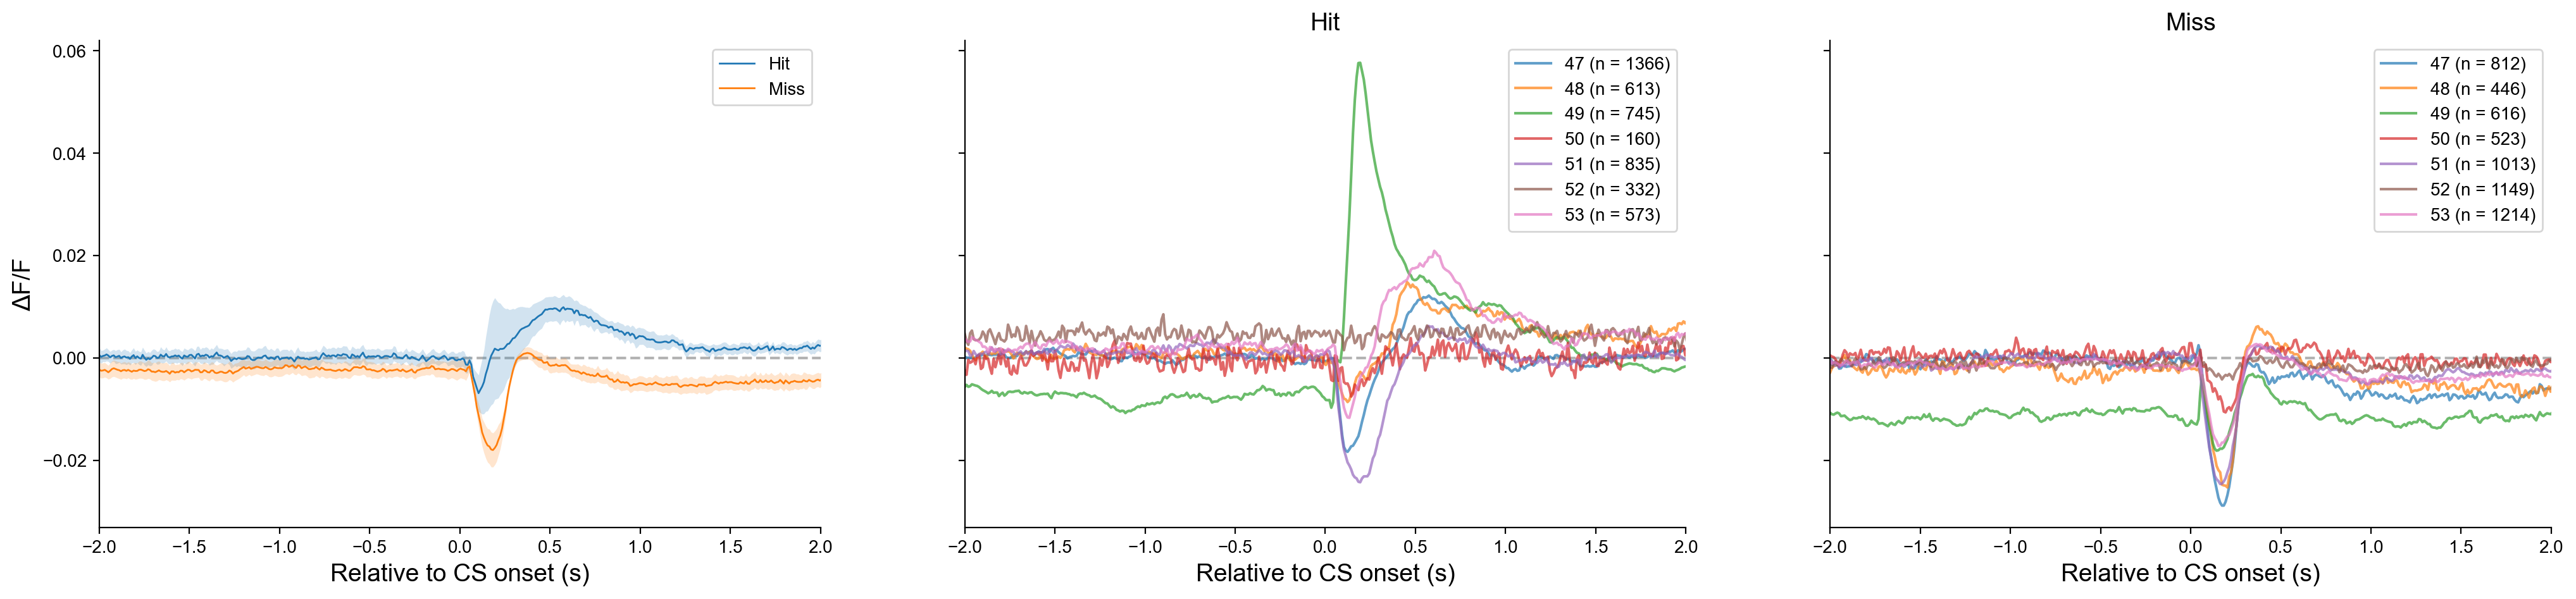

In [18]:

exp_cohort = deepcopy(exp_cohort_copy)  # copy back to recover

exp_cohort.sessions = [session for session in exp_cohort.sessions
                        if # (session.subject_ID in [47, 48, 49, 51, 53]) and
                        (session.number > 2) 
                        and (session.task_name == 'pavlovian_nobar_nodelay')]

cont_dataset = exp_cohort.get_photometry_groups(
    groups=None,  # or use groups variable defined above
    conditions_list=condition_list,
    cond_aliases=cond_aliases,
    when='all',
    task_names='pavlovian_nobar_nodelay',  # 'reaching_go_nogo',
    # align to the first event of a kind e.g. None (meaning CS_Go onset), 'bar_off', 'spout'
    trig_on_ev=None,
    high_pass=None,  # analog_1_df_over_f doesn't work with this
    low_pass=45,
    median_filt=3,
    motion_corr=True,
    df_over_f=True,
    downsampling_factor=10,
    export_vars=['analog_1', 'analog_1_filt', 'analog_2',
                 'analog_2_filt', 'analog_1_df_over_f'],
    verbose=False)

# cont_dataset.filterout_conditions([4,5,6]) # Cued only
# dlist = pd.date_range(datetime.datetime(2022, 4, 1), datetime.datetime(2022, 9, 18)).tolist()
# cont_dataset.filterout_dates(dlist)

cont_dataset.set_trial_window([tw/1000 for tw in trial_window], 's')


fig, axs, df1 = cont_dataset.lineplot(
    vars=['analog_1_df_over_f'],
    time_lim=[-2, 2],
    time_unit='s',
    # [[-0.1, 0.6]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    ylim=None,
    error=True,
    colormap=cmap10(),
    legend=True,
    plot_subjects=True,
    plot_groups=True,
    figsize=(25, 5),
    dpi=200,
    verbose=True)

for r in range(axs.shape[0]):
    if len(axs.shape) > 1:
        for c in range(axs.shape[1]):
            axs[r, c].set_xlabel('Relative to CS onset (s)', fontsize=14)
            axs[r, c].set_title(axs[r, c].get_title('center'), fontsize=14)

    else:
        axs[r].set_xlabel('Relative to CS onset (s)', fontsize=14)

axs[0, 0].set_ylabel('\u0394F/F', fontsize=14)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()

df1


# spout touch

- **Why can I plot Miss against spout touch?**
- What spout are we talking about?

No trial in any condition for subject 49 at: 2022-07-26 15:19:52
No trial in any condition for subject 49 at: 2022-07-27 17:28:51
No trial in any condition for subject 49 at: 2022-07-28 17:16:18
No trial in any condition for subject 53 at: 2022-07-27 18:30:42
cond_ID: 0, group_idx 0, subj 47
cond_ID: 0, group_idx 0, subj 48
cond_ID: 0, group_idx 0, subj 49
cond_ID: 0, group_idx 0, subj 50
cond_ID: 0, group_idx 0, subj 51
cond_ID: 0, group_idx 0, subj 52
cond_ID: 0, group_idx 0, subj 53
cond_ID: 1, group_idx 0, subj 47
cond_ID: 1, group_idx 0, subj 48
cond_ID: 1, group_idx 0, subj 49
cond_ID: 1, group_idx 0, subj 50
cond_ID: 1, group_idx 0, subj 51
cond_ID: 1, group_idx 0, subj 52
cond_ID: 1, group_idx 0, subj 53


,condition_ID,condition_trial_n,condition_alias,group_ID,group_trial_n,subject_ID,subject_trial_n
0,0,4623,Hit,0,4623,47,1365
1,0,4623,Hit,0,4623,48,613
2,0,4623,Hit,0,4623,49,745
3,0,4623,Hit,0,4623,50,160
4,0,4623,Hit,0,4623,51,835
5,0,4623,Hit,0,4623,52,333
6,0,4623,Hit,0,4623,53,572
7,1,958,Miss,0,958,47,194
8,1,958,Miss,0,958,48,98
9,1,958,Miss,0,958,49,111


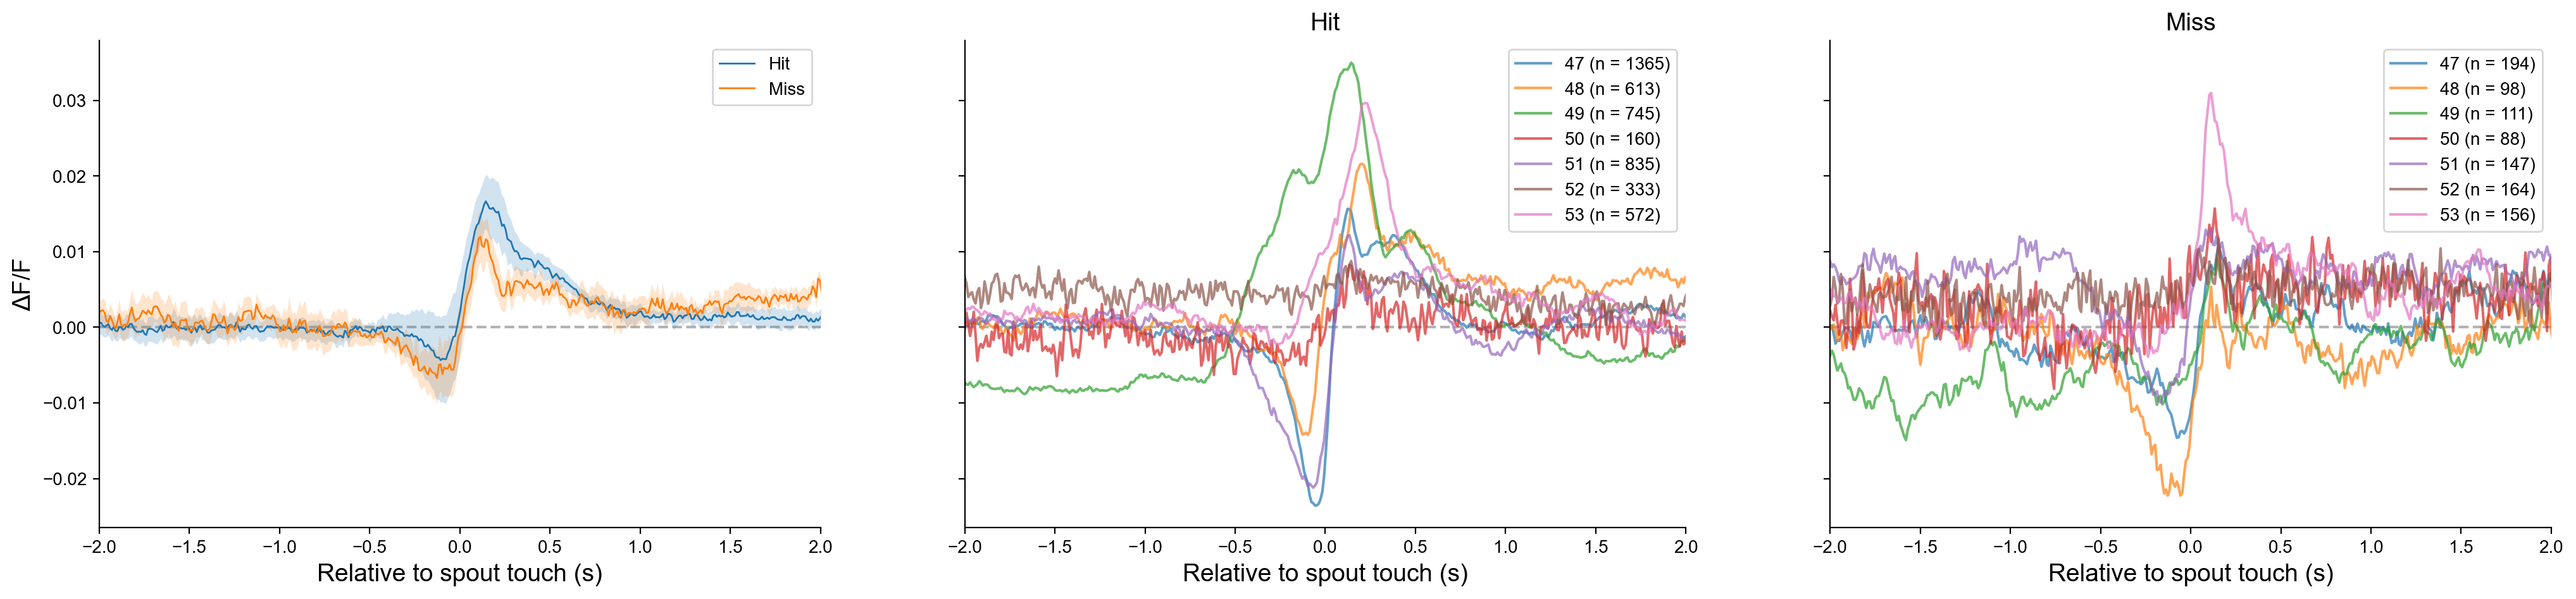

In [19]:

exp_cohort = deepcopy(exp_cohort_copy)  # copy back to recover

exp_cohort.sessions = [session for session in exp_cohort.sessions
                       if  # (session.subject_ID in [47, 48, 49, 51, 53]) and
                       (session.number > 2)
                       and (session.task_name == 'pavlovian_nobar_nodelay')]

cont_dataset = exp_cohort.get_photometry_groups(
    groups=None,  # or use groups variable defined above
    conditions_list=condition_list,
    cond_aliases=cond_aliases,
    when='all',
    task_names='pavlovian_nobar_nodelay',  # 'reaching_go_nogo',
    # align to the first event of a kind e.g. None (meaning CS_Go onset), 'bar_off', 'spout'
    trig_on_ev='spout',
    high_pass=None,  # analog_1_df_over_f doesn't work with this
    low_pass=45,
    median_filt=3,
    motion_corr=True,
    df_over_f=True,
    downsampling_factor=10,
    export_vars=['analog_1', 'analog_1_filt', 'analog_2',
                 'analog_2_filt', 'analog_1_df_over_f'],
    verbose=False)

# cont_dataset.filterout_conditions([4, 5, 6])  # Cued only
# dlist = pd.date_range(datetime.datetime(2022, 4, 1), datetime.datetime(2022, 9, 18)).tolist()
# cont_dataset.filterout_dates(dlist)

cont_dataset.set_trial_window([tw/1000 for tw in trial_window], 's')


fig, axs, df2 = cont_dataset.lineplot(
    vars=['analog_1_df_over_f'],
    time_lim=[-2, 2],
    time_unit='s',
    # [[-0.1, 0.6]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    ylim=None,
    error=True,
    colormap=cmap10(),
    legend=True,
    plot_subjects=True,
    plot_groups=True,
    figsize=(25, 5),
    dpi=200,
    verbose=True)

for r in range(axs.shape[0]):
    if len(axs.shape) > 1:
        for c in range(axs.shape[1]):
            axs[r, c].set_xlabel('Relative to spout touch (s)', fontsize=14)
            axs[r, c].set_title(axs[r, c].get_title('center'), fontsize=14)

    else:
        axs[r].set_xlabel('Relative to spout touch (s)', fontsize=14)

axs[0, 0].set_ylabel('\u0394F/F', fontsize=14)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()

df2


## Select the last five trials

Use 

```python
import heapq
>>> fr = [8,4,1,1,12]
>>> heapq.nlargest(3, xrange(len(fr)), key=fr.__getitem__)
[4, 0, 1]
```


In [68]:
import heapq
exp_cohort = deepcopy(exp_cohort_copy)  # copy back to recover



exp_cohort.sessions = [session for session in exp_cohort.sessions
                       if 
                       (session.number > 2)
                       and (session.task_name == 'pavlovian_nobar_nodelay')]


cont_dataset = exp_cohort.get_photometry_groups(
    groups=None,  # or use groups variable defined above
    conditions_list=condition_list,
    cond_aliases=cond_aliases,
    when='all',
    task_names='pavlovian_nobar_nodelay',  # 'reaching_go_nogo',
    # align to the first event of a kind e.g. None (meaning CS_Go onset), 'bar_off', 'spout'
    trig_on_ev=None,
    high_pass=None,  # analog_1_df_over_f doesn't work with this
    low_pass=45,
    median_filt=3,
    motion_corr=True,
    df_over_f=True,
    downsampling_factor=10,
    export_vars=['analog_1', 'analog_1_filt', 'analog_2',
                 'analog_2_filt', 'analog_1_df_over_f'],
    verbose=False)

cont_dataset.filterout_conditions([50, 52]) # Cued only
# dlist = pd.date_range(datetime.datetime(2022, 4, 1), datetime.datetime(2022, 9, 18)).tolist()
# cont_dataset.filterout_dates(dlist)

# Change cont_dataset.metadata_df['keep'] according to 'session_nb' for each 'subject_ID'


No trial in any condition for subject 49 at: 2022-07-26 15:19:52
No trial in any condition for subject 49 at: 2022-07-27 17:28:51
No trial in any condition for subject 49 at: 2022-07-28 17:16:18
No trial in any condition for subject 53 at: 2022-07-27 18:30:42


In [69]:
c = (cont_dataset.metadata_df['session_nb']).value_counts()
c.sort_index()

3     398
4     898
5     494
6     677
7     410
8     296
9     468
13      2
14    180
16    222
17    251
18    348
19    295
20    462
21    341
22    458
23    428
24    425
25    491
26    346
27    274
28    566
29    116
30    162
31    223
32    224
33    272
34    144
35    139
36    197
37    190
Name: session_nb, dtype: int64

In [70]:
cont_dataset.metadata_df.head()

,subject_ID,datetime,task_name,condition_ID,trial_nb,session_nb,group_ID,keep,trial_ID
0,47,2022-07-26 15:34:02,pavlovian_nobar_nodelay,0,20,3,0,True,0
1,47,2022-07-26 15:34:02,pavlovian_nobar_nodelay,0,21,3,0,True,1
2,47,2022-07-26 15:34:02,pavlovian_nobar_nodelay,0,26,3,0,True,2
3,47,2022-07-26 15:34:02,pavlovian_nobar_nodelay,0,27,3,0,True,3
4,47,2022-07-26 15:34:02,pavlovian_nobar_nodelay,0,28,3,0,True,4


In [71]:
n = 5
subject_IDs = list(set(cont_dataset.metadata_df['subject_ID']))
subject_IDs.sort()


tf = pd.Series([False] * cont_dataset.metadata_df.shape[0])
for s in subject_IDs:
    session_nbs = cont_dataset.metadata_df.loc[:, 'session_nb'].copy() #NOTE copy() is needed

    session_nbs.loc[(
        (cont_dataset.metadata_df['subject_ID'] != s)
        | (cont_dataset.metadata_df['keep'] != True)
        )] = -1

    largestNs = list(set(session_nbs))
    largestNs.sort(reverse=True)

    largestNs = largestNs[0:n]

    if -1  in largestNs:
        largestNs.remove(-1)

    for k in largestNs:
        tf.loc[session_nbs == k] = True


np.count_nonzero(tf)

del session_nbs, s


In [72]:

cont_dataset.metadata_df.loc[:,'keep'] = False
cont_dataset.metadata_df.loc[tf,'keep'] = True


In [73]:
np.count_nonzero(tf)

5523

cond_ID: 0, group_idx 0, subj 47
cond_ID: 0, group_idx 0, subj 48
cond_ID: 0, group_idx 0, subj 49
cond_ID: 0, group_idx 0, subj 50
cond_ID: 0, group_idx 0, subj 51
cond_ID: 0, group_idx 0, subj 52
cond_ID: 0, group_idx 0, subj 53
cond_ID: 1, group_idx 0, subj 47
cond_ID: 1, group_idx 0, subj 48
cond_ID: 1, group_idx 0, subj 49
cond_ID: 1, group_idx 0, subj 50
cond_ID: 1, group_idx 0, subj 51
cond_ID: 1, group_idx 0, subj 52
cond_ID: 1, group_idx 0, subj 53


,condition_ID,condition_trial_n,condition_alias,group_ID,group_trial_n,subject_ID,subject_trial_n
0,0,3141,Hit,0,3141,47,885
1,0,3141,Hit,0,3141,48,561
2,0,3141,Hit,0,3141,49,429
3,0,3141,Hit,0,3141,50,160
4,0,3141,Hit,0,3141,51,590
5,0,3141,Hit,0,3141,52,181
6,0,3141,Hit,0,3141,53,335
7,1,2382,Miss,0,2382,47,112
8,1,2382,Miss,0,2382,48,294
9,1,2382,Miss,0,2382,49,151


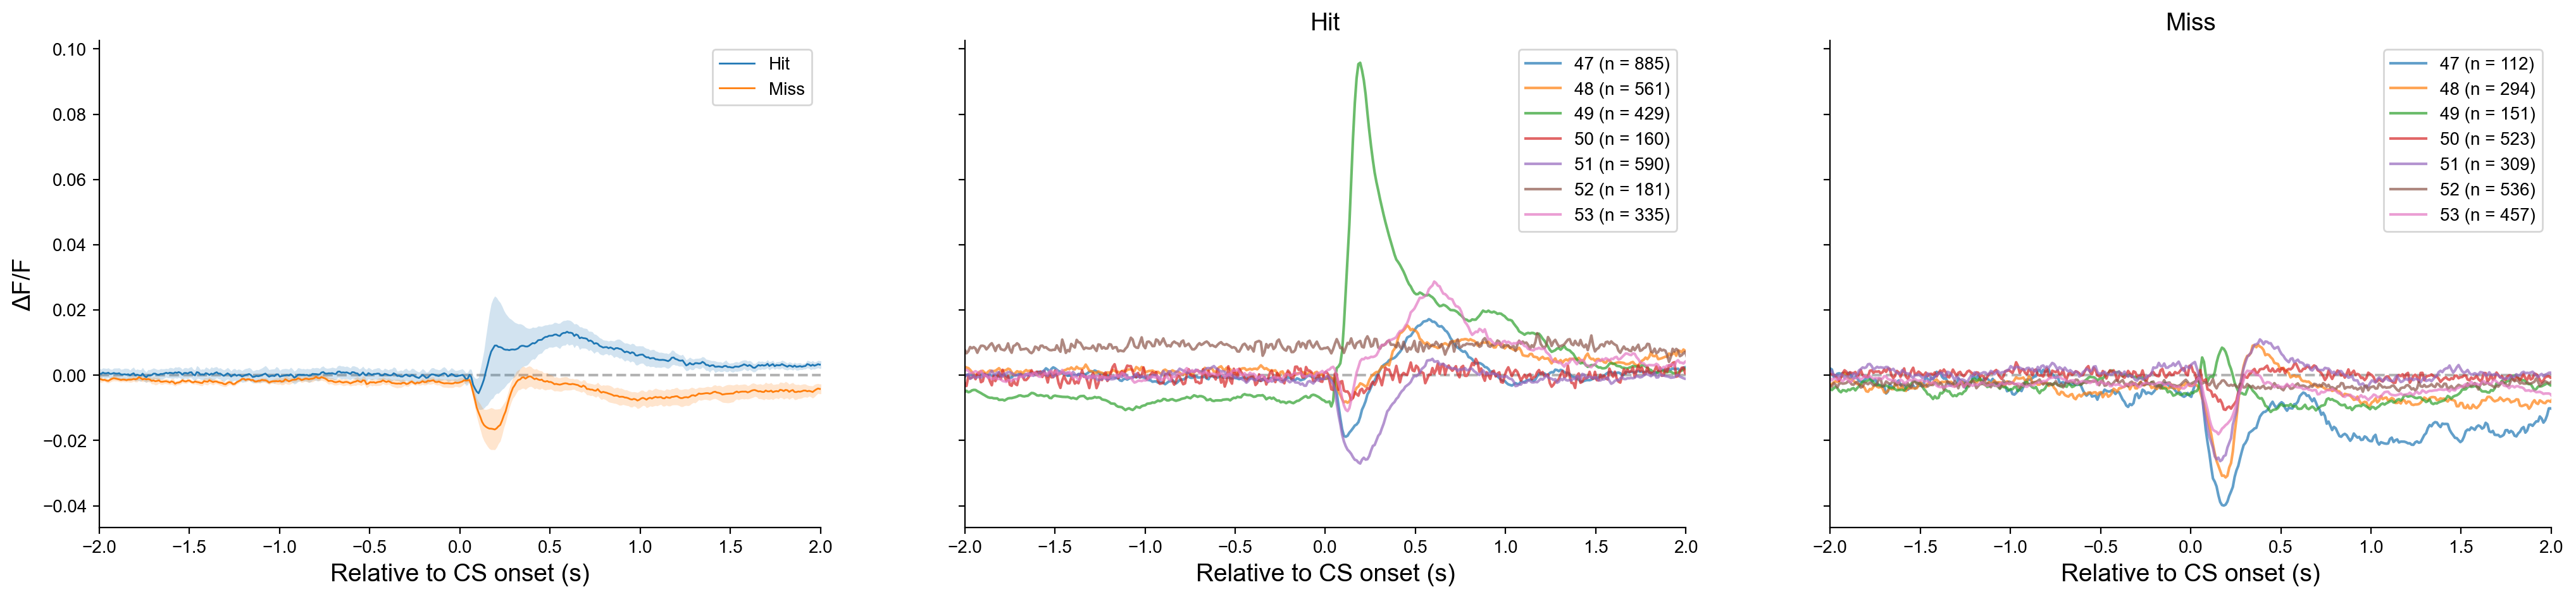

In [74]:

cont_dataset.set_trial_window([tw/1000 for tw in trial_window], 's')


fig, axs, df1 = cont_dataset.lineplot(
    vars=['analog_1_df_over_f'],
    time_lim=[-2, 2],
    time_unit='s',
    # [[-0.1, 0.6]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    ylim=None,
    error=True,
    colormap=cmap10(),
    legend=True,
    plot_subjects=True,
    plot_groups=True,
    figsize=(25, 5),
    dpi=200,
    verbose=True)

for r in range(axs.shape[0]):
    if len(axs.shape) > 1:
        for c in range(axs.shape[1]):
            axs[r, c].set_xlabel('Relative to CS onset (s)', fontsize=14)
            axs[r, c].set_title(axs[r, c].get_title('center'), fontsize=14)

    else:
        axs[r].set_xlabel('Relative to CS onset (s)', fontsize=14)

axs[0, 0].set_ylabel('\u0394F/F', fontsize=14)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()

df1
